## Integrator Optimal Control

This notebook demonstrates how to use `SimInterface` with a simple optimal control example.

## Initialization

In [1]:
%matplotlib inline
import SimInterface as SI
import SimInterface.samplingControl as SC
import numpy as np
import matplotlib.pyplot as plt

## Defining the System

We will examine a simple optimal control problem:
\begin{equation*}
\begin{array}{cl}
\min_{u} &\int_0^T \left(x_t^2 + u_t^2\right) dt \\
\textrm{subject to } & \dot x_t = u_t,
\end{array}
\end{equation*}
with a fixed initial condition, $x_0 = 10$ and fixed final time $T$.

In [2]:
class Integrator(SI.linearQuadraticSystem):
    """
    This is the simplest linear system dynamical system
    """
    def __init__(self):
        self.dt = 0.1
        self.x0 = 10.0
        A = 1.
        B = self.dt
        Q = self.dt * 1.
        R = self.dt * 1.
        dynMat = SI.buildDynamicsMatrix(A,B)
        costMat = SI.buildCostMatrix(Cxx=Q,Cuu=R)
        SI.linearQuadraticSystem.__init__(self,dynamicsMatrix=dynMat,
                                           costMatrix=costMat,x0 = self.x0)
sys = Integrator()

The `linearQuadraticSystem` class implements dynamics of the form:
\begin{equation*}
    x_{k+1} = \begin{bmatrix}D_1 & D_x & D_u \end{bmatrix}
    \begin{bmatrix}
        1 \\
        x_k \\
        u_k
    \end{bmatrix}
\end{equation*}
with a quadratic cost given by
\begin{equation*}
    \sum_{k=0}^{N-1} 
    \begin{bmatrix}
        1 \\
        x_k \\
        u_k
    \end{bmatrix}'
    \begin{bmatrix}
    C_{11} & C_{1x} & C_{1u} \\
    C_{x1} & C_{xx} & C_{xu} \\
    C_{u1} & C_{ux} & C_{uu}
    \end{bmatrix}
    \begin{bmatrix}
        1 \\
        x_k \\
        u_k
    \end{bmatrix}.
\end{equation*}

In order to cast the integrator system into this form, we first perform an Euler approximation. We then utilize the helper functions `buildDynamicsMatrix` and `buildCostMatrix` to build the required matrices from the more common $A$, $B$, $Q$,and $R$ matrices.

## Controller Comparison

Now we will compare a several control methods. 

In [3]:
T = 100 # The Horizon
Controllers = [] # An empty list to store the controllers.

The most basic controller is a static gain:
\begin{equation*}
u_t = -\frac{1}{2} x_t
\end{equation*}

In [4]:
staticCtrl = SI.staticGain(gain=-.5,Horizon=T,label='Static')
Controllers.append(staticCtrl)

We can also use a linear quadratic regulator. Note that for the linear quadratic regulator, we pass the system as parameter to the control method, and then the regulator is constructed. 

A model predictive controller is constructed similarly.

In [5]:
lqrCtrl = SI.linearQuadraticRegulator(SYS=sys,Horizon=T,label='LQR')
Controllers.append(lqrCtrl)

mpcCtrl = SI.modelPredictiveControl(SYS=sys,
                                    predictiveHorizon=5,
                                    Horizon=T,
                                    label='MPC')
Controllers.append(mpcCtrl)

We can also compute control the control using only sequences of costs using an actor-critic algorithm.

In [6]:
actorCriticCtrl = SI.actorCriticLQR(SYS=sys,Horizon=T,reset=False,
                                    Covariance=np.array([[1.0]]),
                                    EpisodeLength=T,EpisodeCount=100,
                                    TraceDecayFactor = .1,
                                    DiscountFactor = .95,
                                    ForgettingFactor = .99,
                                    label='Actor Critic')
Controllers.append(actorCriticCtrl)

Episode Cost: 190.637, Estimated Episode Cost: 202.38, Undiscounted Cost: 976.635
Episode Cost: 86.8941, Estimated Episode Cost: 259.634, Undiscounted Cost: 146.322
Episode Cost: 4.62527, Estimated Episode Cost: 20.2366, Undiscounted Cost: 32.5673
Episode Cost: 9.27711, Estimated Episode Cost: 1.77484, Undiscounted Cost: 45.7538
Episode Cost: 8.42496, Estimated Episode Cost: 2.0536, Undiscounted Cost: 49.4951
Episode Cost: 10.0035, Estimated Episode Cost: 1.51353, Undiscounted Cost: 49.6142
Episode Cost: 8.35536, Estimated Episode Cost: 3.71869, Undiscounted Cost: 47.9717
Episode Cost: 9.95864, Estimated Episode Cost: 3.18932, Undiscounted Cost: 47.5708
Episode Cost: 9.80478, Estimated Episode Cost: 3.90157, Undiscounted Cost: 48.4531
Episode Cost: 9.26426, Estimated Episode Cost: 4.17719, Undiscounted Cost: 48.1101
Episode Cost: 10.3281, Estimated Episode Cost: 5.71819, Undiscounted Cost: 52.428
Episode Cost: 9.78741, Estimated Episode Cost: 5.82563, Undiscounted Cost: 49.1886
Episode

## Comparison and Plotting

With all the controllers now defined, we can simulate each of them and plot the results.


Comparing Controllers

Static: 128.201
LQR: 105.125
MPC: 155.746
Actor Critic: 177.312


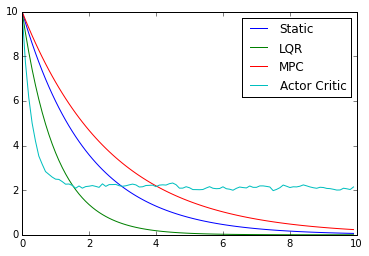

In [7]:
NumControllers = len(Controllers)
X = np.zeros((NumControllers,T,1))
Cost = np.zeros((NumControllers,T))
Time = sys.dt * np.arange(staticCtrl.Horizon)
plt.figure(1)
plt.clf()
line = []

print '\nComparing Controllers\n'

for k in range(NumControllers):
    controller = Controllers[k]
    name = controller.label

    X[k], U, Cost[k] = sys.simulatePolicy(controller)
    print '%s: %g' % (name,Cost[k].sum())
    handle = plt.plot(Time,X[k],label=name)[0]
    line.append(handle)

plt.legend(handles=line)

In [8]:
actorCriticCtrl.beta, actorCriticCtrl.C

(array([ 6.160555  , -2.87016448]), array([[ 0.54325164]]))